In [1]:
%matplotlib inline

# Semantic Segmentation Training
This notebook trains a U-Net model on the SUN RGB-D dataset to segment room layouts and furniture.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import ToTensor
from torchvision import transforms
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

from PIL import Image

import os
import glob
import re

from tqdm import tqdm


In [3]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [4]:
writer = SummaryWriter(log_dir="C:/Project Deep Learning/logs")

In [5]:
writer

# Image and Label Transformation


In [6]:
# Transform for RGB images
transform = transforms.Compose([
    transforms.Resize((256, 256)),   # Resize images to a fixed size
    transforms.ToTensor(),            # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

# Transform for label images (ensuring integer class indices and resizing)
label_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),  # Resize with nearest neighbor
    transforms.Lambda(lambda x: torch.from_numpy(np.array(x)).long())  # Convert to tensor with integer values
])

# Apply transformations in the dataset class
class SUNRGBDDataset(Dataset):
    def __init__(self, dataframe, rgb_dir, label_dir, transform=None, label_transform=None):
        self.dataframe = dataframe
        self.rgb_dir = rgb_dir
        self.label_dir = label_dir
        self.transform = transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]  # RGB image file name
        label_name = self.dataframe.iloc[idx, 1]  # Label image file name
        
        # Construct full paths
        img_path = os.path.join(self.rgb_dir, img_name)
        label_path = os.path.join(self.label_dir, label_name)

        # Load the images
        rgb_image = Image.open(img_path).convert("RGB")
        label_image = Image.open(label_path).convert("L")  # Convert to grayscale if necessary

        label_array = np.array(label_image)

        # Apply transformations to RGB image
        if self.transform:
            rgb_image = self.transform(rgb_image)

        # Apply transformations to label image
        if self.label_transform:
            label_image = self.label_transform(label_image)
        
        return rgb_image, label_image


This code defines image transformations for the **RGB** and **label** images:
- **RGB images** are resized to 256x256, converted to tensor format, and normalized with ImageNet statistics.
- **Label images** are resized using nearest neighbor interpolation and converted to integer tensors for segmentation classes.

The `SUNRGBDDataset` class applies these transformations to the images when loading data for training.


# Dataset Paths and Splits

The paths to the RGB and label directories are defined, and CSV files containing the training, validation, and test splits are loaded. Using these paths and splits, the corresponding datasets are created for each phase (training, validation, and testing) by applying the previously defined transformations.


In [7]:
# Paths to the directories
rgb_dir = "C:/Project Deep Learning/data"
labels_dir = "C:/Project Deep Learning/data/labels_37"

# Define the paths to training and validation splits
train_df = pd.read_csv("C:/Project Deep Learning/data/splits/train_split.csv")
valid_df = pd.read_csv("C:/Project Deep Learning/data/splits/valid_split.csv")
test_df = pd.read_csv("C:/Project Deep Learning/data/splits/test_split.csv")

# Create datasets 
train_dataset = SUNRGBDDataset(train_df, rgb_dir, labels_dir, transform, label_transform)
valid_dataset = SUNRGBDDataset(valid_df, rgb_dir, labels_dir, transform, label_transform)
test_dataset = SUNRGBDDataset(test_df, rgb_dir, labels_dir, transform, label_transform)

# Dataloaders

In [8]:
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

The `DataLoader` is used to load the training, validation, and test datasets in batches. 
- **Training** data is shuffled and loaded with a batch size of 8.
- **Validation** and **test** data are loaded without shuffling, also with a batch size of 8.

# Define the Model


## U-Net Model with ResNet-34 Backbone

In [9]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",   # ResNet-34 backbone
    encoder_weights="imagenet", # Use pretrained weights
    classes=38,                 # Number of segmentation classes
)


In [10]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))  


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

# Define loss function and optimizer

In [11]:
criterion = nn.CrossEntropyLoss()  # For multi-class segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


weight_decay=1e-4 applies __L2 regularization__. Can increase it (e.g., 1e-3) if overfitting is still an issue.

# Training Loop

In [28]:
# Find the latest checkpoint file
checkpoint_files = sorted(glob.glob("C:/Project Deep Learning/models/checkpoint_epoch_*.pth"), key=lambda x: int(x.split('_')[-1].split('.')[0]))

if checkpoint_files:
    # if len(checkpoint_files) > 3:
    #     os.remove(checkpoint_files[0])
    #     print(f"🗑️ Removed old checkpoint: {checkpoint_files[0]}")
        
    latest_checkpoint = checkpoint_files[-1]  # Pick the most recent checkpoint
    checkpoint = torch.load(latest_checkpoint, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"✅ Resuming training from {latest_checkpoint} (Epoch {start_epoch})")
else:
    start_epoch = 0  # Start from scratch if no checkpoint is found

✅ Resuming training from C:/Project Deep Learning/models\checkpoint_epoch_11.pth (Epoch 11)


In [ ]:
num_epochs = 15

# Training loop
for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_idx, (rgb_images, label_images) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        rgb_images = rgb_images.to(device)
        label_images = label_images.to(device)

        optimizer.zero_grad()
        outputs = model(rgb_images)
        loss = criterion(outputs, label_images)
        loss.backward()
        
        # Debug: Check for NaN gradients
        for name, param in model.named_parameters():
            if param.grad is not None and torch.isnan(param.grad).any():
                print(f"NaN gradient detected in {name}")
                
            if param.grad is not None:
                gradient_norm = param.grad.norm().item()
                writer.add_scalar(f'Gradients/{name}_norm', gradient_norm, epoch * len(train_loader) + batch_idx)
            
        optimizer.step()
        running_loss += loss.item()

        # Debugging loss values
        if batch_idx <= 5:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    # Compute average loss
    epoch_loss = running_loss / len(train_loader)
    print(f"🔹 Epoch {epoch+1}/{num_epochs} - Average Loss: {epoch_loss:.4f}")
    
    # Log training loss to TensorBoard
    writer.add_scalar('Loss/train', epoch_loss, epoch)
    
    # Save checkpoint with epoch number in filename
    checkpoint_path = f"C:/Project Deep Learning/models/checkpoint_epoch_{epoch+1}.pth"
    checkpoint = {
        'epoch': epoch + 1,  # Save the next epoch number
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"✅ Checkpoint saved at '{checkpoint_path}' (Epoch {epoch+1})")

    # Log the updated learning rate for the next epoch
    for param_group in optimizer.param_groups:
        epoch_lr = param_group['lr']
    writer.add_scalar('Learning Rate', epoch_lr, epoch)
    
    # Step the scheduler to update learning rate
    # scheduler.step()


    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for rgb_images, label_images in valid_loader:
            rgb_images = rgb_images.to(device)
            label_images = label_images.to(device)

            if label_images.dim() == 4:
                label_images = label_images.squeeze(1)

            outputs = model(rgb_images)
            loss = criterion(outputs, label_images)
            val_loss += loss.item()

    val_loss /= len(valid_loader)
    print(f"📉 Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")
    
    scheduler.step(val_loss) # for ReduceLROnPlateau
                      
    # Log validation loss to TensorBoard
    writer.add_scalar('Loss/val', val_loss, epoch)


Epoch 12/15:   0%|                                                                  | 1/1034 [00:05<1:41:49,  5.91s/it]

Batch 0, Loss: 1.0258933305740356


Epoch 12/15:   0%|▏                                                                 | 2/1034 [00:12<1:44:30,  6.08s/it]

Batch 1, Loss: 0.7930569052696228


Epoch 12/15:   0%|▏                                                                 | 3/1034 [00:17<1:40:59,  5.88s/it]

Batch 2, Loss: 0.7206921577453613


Epoch 12/15:   0%|▎                                                                 | 4/1034 [00:23<1:38:38,  5.75s/it]

Batch 3, Loss: 1.008651614189148


Epoch 12/15:   0%|▎                                                                 | 5/1034 [00:28<1:36:37,  5.63s/it]

Batch 4, Loss: 1.000016689300537


Epoch 12/15:   1%|▍                                                                 | 6/1034 [00:34<1:35:33,  5.58s/it]

Batch 5, Loss: 0.9406562447547913


Epoch 12/15:  22%|█████████████▊                                                  | 224/1034 [20:58<1:14:50,  5.54s/it]

In [14]:
writer.close()

# Load the model

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the same model architecture
model = smp.Unet(
    encoder_name="resnet34",   
    encoder_weights="imagenet",
    classes=38,                
)

# Load the trained weights
model.load_state_dict(torch.load('C:/Project Deep Learning/models/segmentation_model.pth', map_location=device, weights_only=True))

# Move model to device
model.to(device)

# Set model to evaluation mode
model.eval()
print("✅ Model loaded!")


✅ Model loaded!


# Evaluation


In [16]:
print(f"Total test batches: {len(test_loader)}")

Total test batches: 130


In [17]:
for images, masks in test_loader:
    print(f"Images shape: {images.shape}")  # Should be (batch_size, channels, height, width)
    print(f"Masks shape: {masks.shape}")   # Should be (batch_size, height, width)
    break  # Only check the first batch

Images shape: torch.Size([8, 3, 256, 256])
Masks shape: torch.Size([8, 256, 256])


In [18]:
# outputs = model(images)  # Shape will be (batch_size, num_classes, height, width)
# outputs = torch.softmax(outputs, dim=1)  # Apply softmax along the class dimension (dim=1)


# Forward pass
outputs = model(images)  # Raw logits

# Apply softmax
probs = torch.nn.functional.softmax(outputs, dim=1)

# Get the most confident class per pixel
preds = torch.argmax(probs, dim=1)


In [19]:
predictions = torch.argmax(outputs, dim=1)  # Get the predicted class for each pixel
predictions

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [0, 2, 2,  ..., 2, 2, 2]],

        [[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 4, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 9, 0, 0],
         [0, 0, 0,  ..., 9, 0, 0],
         ...,
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [0, 2, 2,  ..., 2, 2, 2]],

        [[0, 0, 0,  ..., 1, 1, 0],
         [0, 0, 0,  ..., 9, 1, 0],
         [0,

In [20]:
print(f"Predictions shape: {predictions.shape}")
print(f"Masks shape: {masks.shape}")

Predictions shape: torch.Size([8, 256, 256])
Masks shape: torch.Size([8, 256, 256])


In [21]:
def class_wise_metrics(preds, masks, num_classes):
    class_iou = []
    class_dice = []
    class_accuracy = []

    for class_idx in range(num_classes):
        pred_class = (preds == class_idx).float()
        target_class = (masks == class_idx).float()

        # IoU
        intersection = (pred_class * target_class).sum()
        union = pred_class.sum() + target_class.sum()
        iou = (intersection + 1e-6) / (union - intersection + 1e-6)
        class_iou.append(iou.item())

        # Dice
        dice = (2 * intersection + 1e-6) / (pred_class.sum() + target_class.sum() + 1e-6)
        class_dice.append(dice.item())

        # Accuracy
        correct = (pred_class == target_class).sum()
        total = target_class.numel()
        accuracy = correct / total
        class_accuracy.append(accuracy.item())

    return class_iou, class_dice, class_accuracy


# Compute class-wise metrics
num_classes = 38
class_iou, class_dice, class_accuracy = class_wise_metrics(predictions, masks, num_classes=num_classes)

# Compute average metrics
avg_iou = sum(class_iou) / num_classes
avg_dice = sum(class_dice) / num_classes
avg_accuracy = sum(class_accuracy) / num_classes

# Print results
print(f"Average IoU: {avg_iou:.4f}, Average Dice: {avg_dice:.4f}, Average Accuracy: {avg_accuracy:.4f}")
for class_idx in range(num_classes):
    print(f"Class {class_idx}: IoU = {class_iou[class_idx]:.4f}, Dice = {class_dice[class_idx]:.4f}, Accuracy = {class_accuracy[class_idx]:.4f}")

Average IoU: 0.4890, Average Dice: 0.5178, Average Accuracy: 0.9801
Class 0: IoU = 0.3689, Dice = 0.5390, Accuracy = 0.7063
Class 1: IoU = 0.3857, Dice = 0.5566, Accuracy = 0.9001
Class 2: IoU = 0.7792, Dice = 0.8759, Accuracy = 0.9454
Class 3: IoU = 0.0000, Dice = 0.0000, Accuracy = 0.9855
Class 4: IoU = 0.0000, Dice = 0.0000, Accuracy = 0.9968
Class 5: IoU = 0.6654, Dice = 0.7991, Accuracy = 0.9418
Class 6: IoU = 0.1718, Dice = 0.2932, Accuracy = 0.9799
Class 7: IoU = 0.6387, Dice = 0.7795, Accuracy = 0.9717
Class 8: IoU = 0.0000, Dice = 0.0000, Accuracy = 0.9932
Class 9: IoU = 0.0000, Dice = 0.0000, Accuracy = 0.9791
Class 10: IoU = 0.4699, Dice = 0.6394, Accuracy = 0.9790
Class 11: IoU = 0.0000, Dice = 0.0000, Accuracy = 0.9996
Class 12: IoU = 1.0000, Dice = 1.0000, Accuracy = 1.0000
Class 13: IoU = 0.0000, Dice = 0.0000, Accuracy = 1.0000
Class 14: IoU = 0.0589, Dice = 0.1113, Accuracy = 0.9249
Class 15: IoU = 1.0000, Dice = 1.0000, Accuracy = 1.0000
Class 16: IoU = 0.0121, Dice =

## Model Performance Summary

### Overall Metrics
- **Average IoU**: 0.4890  
  The model shows moderate segmentation performance, with an average Intersection over Union (IoU) of 0.4890.

- **Average Dice**: 0.5178  
  The model's average Dice coefficient suggests that it is fairly consistent in capturing the relevant segments in the dataset.

- **Average Accuracy**: 0.9801  
  The model achieves a high accuracy, indicating that it is correctly classifying most pixels, though this does not necessarily correlate with segmentation quality.

### Per-Class Performance
- **High Performance**:
  - **Class 12**: IoU = 1.0000, Dice = 1.0000, Accuracy = 1.0000  
    Perfect performance with full segmentation accuracy.
  - **Class 15, 17, 19, 20, 22, 24, 27, 28, 30, 31, 32, 33, 34, 36**: IoU = 1.0000, Dice = 1.0000, Accuracy = 1.0000  
    All these classes achieved perfect segmentation results.
  
- **Moderate Performance**:
  - **Class 2**: IoU = 0.7792, Dice = 0.8759, Accuracy = 0.9454  
    Strong segmentation with a high Dice score, indicating good model performance.
  - **Class 5**: IoU = 0.6654, Dice = 0.7991, Accuracy = 0.9418  
    Good performance, with some room for improvement in segmentation accuracy.
  - **Class 7**: IoU = 0.6387, Dice = 0.7795, Accuracy = 0.9717  
    Strong segmentation performance, though the IoU could be higher.

- **Lower Performance**:
  - **Class 0**: IoU = 0.3689, Dice = 0.5390, Accuracy = 0.7063  
    Relatively poor segmentation performance, indicating challenges with this class.
  - **Class 1**: IoU = 0.3857, Dice = 0.5566, Accuracy = 0.9001  
    Somewhat poor performance, suggesting that the model struggles with this class.
  - **Class 6**: IoU = 0.1718, Dice = 0.2932, Accuracy = 0.9799  
    Very low IoU and Dice scores, indicating significant segmentation difficulties.
  - **Class 3, 4, 8, 9, 11, 13, 14, 16, 18, 21, 23, 25, 26, 29, 35, 37**: IoU = 0.0000 or very low IoU, indicating poor segmentation results for these classes.

### Insights
- **Strengths**: The model performs exceptionally well on many classes, especially where IoU and Dice are both perfect (1.0). 
- **Challenges**: There are several classes where the model struggles with segmentation, especially those with low IoU and Dice values (e.g., Class 0, 1, 3, 4, 6, etc.).
- **Potential Improvements**:
  - Should use data augmentation techniques to improve performance on difficult classes.


In [ ]:
# print("Unique values in targets:", torch.unique(targets))
# print("Unique values in preds:", torch.unique(predictions))
# plt.imshow(targets[0].cpu().numpy(), cmap='gray')
# plt.title("Full Ground Truth")
# plt.show()

# plt.imshow(predictions[0].cpu().numpy(), cmap='gray')
# plt.title("Full Prediction")
# plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(targets[0].cpu().numpy(), cmap="jet")  # different colors for every class
plt.colorbar()
plt.title(f"Ground Truth for Image {0}")
plt.show()


In [ ]:
class_counts = torch.bincount(predictions.flatten())
print("Class frequencies:", class_counts)


In [ ]:
print("Predictions sample:", predictions[0, :10])  # Sample from the first batch (first 10 values)
print("Targets sample:", targets[0, :10])  # Same for targets


Visualizing batch 1...


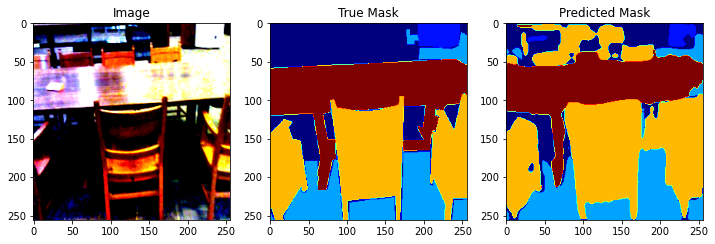

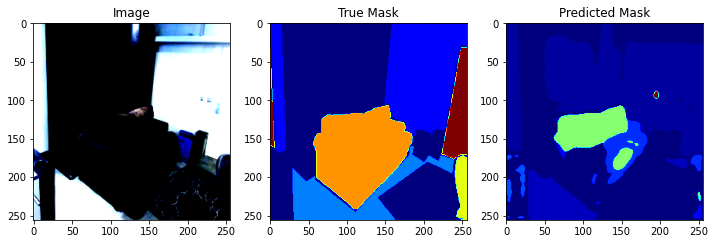

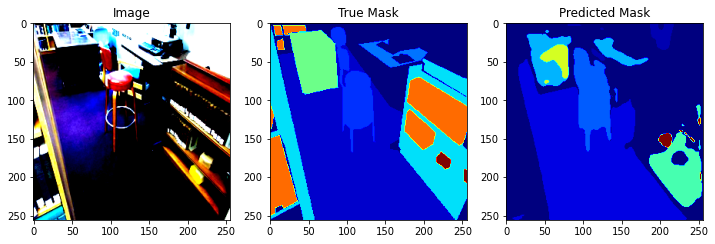

Visualizing batch 2...


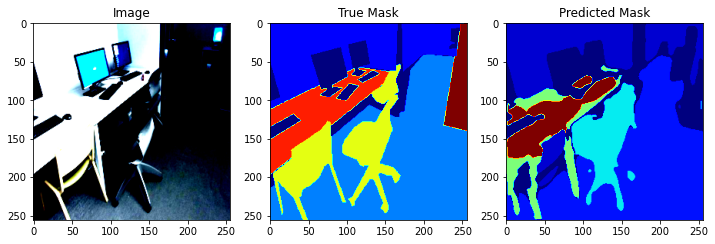

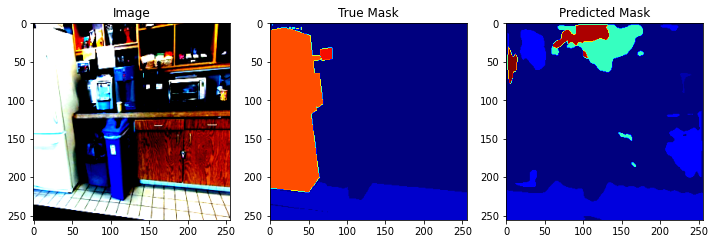

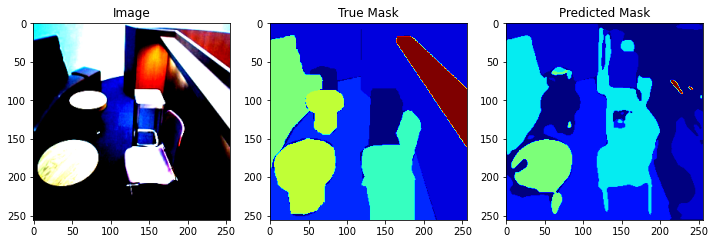

Visualizing batch 3...


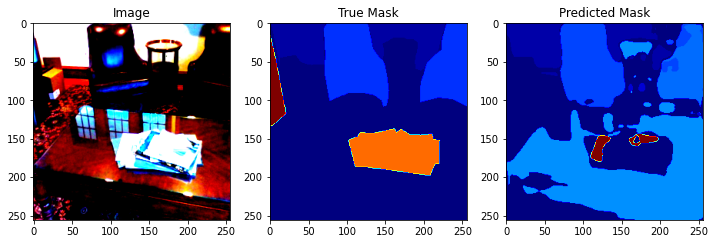

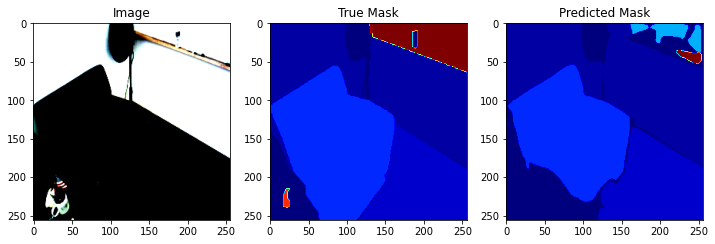

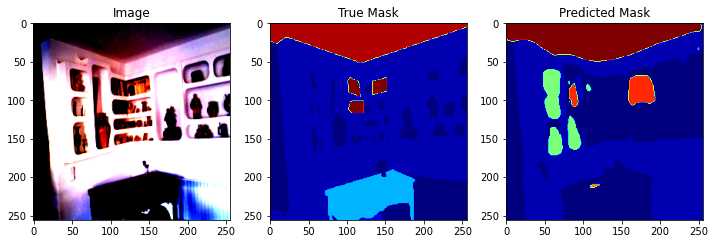

In [24]:
def visualize_predictions(images, masks, preds, num_samples=3):
    batch_size = images.shape[0]  # Get the actual batch size
    num_samples = min(num_samples, batch_size)  # Ensure we don't exceed the batch size

    for i in range(num_samples):
        # Normalize image to [0, 1] for visualization
        image = images[i].cpu().permute(1, 2, 0).numpy()
        image = np.clip(image, 0, 1)  # Clip values to [0, 1]

        # Convert masks to 2D if they are one-hot encoded
        true_mask = masks[i].cpu().numpy()
        pred_mask = preds[i].cpu().numpy()

        if true_mask.ndim == 3:  # If one-hot encoded, convert to 2D
            true_mask = np.argmax(true_mask, axis=0)
        if pred_mask.ndim == 3:  # If one-hot encoded, convert to 2D
            pred_mask = np.argmax(pred_mask, axis=0)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(image)

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(true_mask, cmap="jet")

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask, cmap="jet")

        plt.show()

# Visualize predictions from multiple batches
num_batches_to_visualize = 3  # Number of batches to visualize
samples_per_batch = 3  # Number of samples to visualize per batch

for batch_idx, (images, masks) in enumerate(test_loader):
    if batch_idx >= num_batches_to_visualize:
        break  # Stop after visualizing the desired number of batches

    images, masks = images.to(device), masks.to(device)

    # Forward pass
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

    # Visualize predictions for this batch
    print(f"Visualizing batch {batch_idx + 1}...")
    visualize_predictions(images, masks, preds, num_samples=samples_per_batch)

# Save the Model

In [ ]:
# torch.save(model.state_dict(), 'C:/Project Deep Learning/models/segmentation_model.pth')

# Make predictions on unseen data

In [25]:
class SegmentationPredictor:
    def __init__(self, model, device="cpu", image_size=(256, 256)):
        """Initialize the predictor with a trained model."""
        self.model = model.to(device)
        self.device = device
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor()
        ])
        self.model.eval()

    def predict(self, image_path):
        """Perform segmentation on a single image."""
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            output = self.model(image)
        
        output = output.squeeze(0).cpu().numpy()
        segmentation_mask = np.argmax(output, axis=0)
        
        return image_path, segmentation_mask
    
    def visualize(self, image_path, segmentation_mask):
        """Display the original image and segmentation mask."""
        image = Image.open(image_path)
        
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(image)
        ax[0].set_title("Original Image")
        ax[0].axis("off")
        
        ax[1].imshow(segmentation_mask, cmap="jet")
        ax[1].set_title("Segmentation Mask")
        ax[1].axis("off")
        
        plt.show()


We can reuse this SegmentationPredictor class for any image path by calling ```predictor.predict(image_path)``` and ```predictor.visualize(image_path, segmentation_mask)```

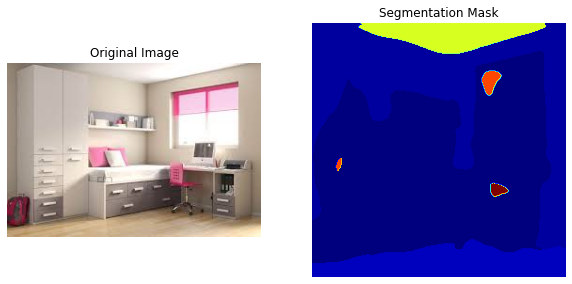

In [26]:
image_path = "C:/Project Deep Learning/outputs/test/test_image.jpg"
predictor = SegmentationPredictor(model, device="cuda" if torch.cuda.is_available() else "cpu")
img_path, seg_mask = predictor.predict(image_path)
predictor.visualize(img_path, seg_mask)

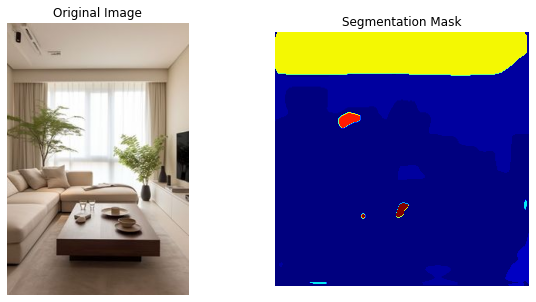

In [27]:
image_path = "C:/Project Deep Learning/data/pinterest/living_room/minimalist/living_room_minimalist_1.jpg"
predictor = SegmentationPredictor(model, device="cuda" if torch.cuda.is_available() else "cpu")
img_path, seg_mask = predictor.predict(image_path)
predictor.visualize(img_path, seg_mask)

# **Model Training Experiments and Findings**

## **1. Initial Model and Best Results**
- The main model used for training is based on **U-Net** with a **ResNet-34** encoder.
- The best model so far is saved as **`segmentation_model.pth`**.
- Checkpoints **`checkpoint_epoch_11`** and **`checkpoint_epoch_15`** were created using this architecture, but performance degraded after 10 epochs due to **overfitting**.

### **Model Architecture**

```python
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",   
    encoder_weights="imagenet", 
    classes=38,                 
)
```


### **Loss Function and Optimizer**
```python
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
```

---

## **2. Experimenting with Dropout for Regularization**
- A modified **U-Net (ResNet-34)** model was tested with **dropout** to reduce overfitting.
- The last saved checkpoint for this model was **`checkpoint_epoch_3`**.
- However, the results were **worse** compared to the initial model.

### **Modified Model with Dropout**
```python
model = smp.Unet(
    encoder_name="resnet34",   
    encoder_weights="imagenet", 
    classes=38,                
    encoder_depth=5,           
    decoder_channels=(256, 128, 64, 32, 16),  
    decoder_dropout=0.3           
)
```

### **Computing Class Weights**
- To handle class imbalance, weights were computed using compute_class_weight from sklearn.utils.
- However, this did not help improve the results.

```python
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

all_labels = []
for _, labels in train_loader:
    all_labels.append(labels.view(-1).numpy())  

all_labels = np.concatenate(all_labels) 

class_weights = compute_class_weight(class_weight="balanced", classes=np.arange(38), y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)  

```


### **Loss Function and Optimizer**
```python
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
```

---

## **3. Experimenting with a More Powerful Encoder (EfficientNet-B4)**
- Tried replacing **ResNet-34** with **EfficientNet-B4**, adding **attention mechanisms** and **dropout**.
- Used **SCSE (Squeeze-and-Excitation)** attention for improved segmentation.
- Applied **ReduceLROnPlateau** scheduler for adaptive learning rate adjustment.
- Performance was **not better** than the initial model.

### **EfficientNet-B4 Model with Attention & Dropout**
```python
model = smp.Unet(
    encoder_name="efficientnet-b4",  
    encoder_weights="imagenet",  
    classes=38,  
    encoder_depth=5,  
    decoder_channels=(256, 128, 64, 32, 16),  
    decoder_dropout=0.3,  
    encoder_dropout=0.2, 
    decoder_attention_type="scse"  
)
```

### **Loss Function and Optimizer**
```python
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)
```

---

## **4. Conclusion**
- **The best model so far** is the **U-Net with ResNet-34** (**`segmentation_model.pth`**).
- **Overfitting** was observed after **10 epochs**, making later checkpoints **less effective**.
- Adding **dropout** did not improve performance.
- Switching to **EfficientNet-B4** and using **attention mechanisms** did not yield better results.
- Experimented with different **learning rate schedulers**, but none provided significant improvement.
